In [1]:

import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns
import lightgbm as lgb
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status
from utils.utils import customIter, cross_validation_on_validation_set, ensemble_submissions, ensemble_submissions_uncertainty
from utils.metrics import WSPL
from utils.configure_logger import configure_logger
from utils.utils import prefixes_in_column, prefix_in_column, parse_columns_to_string
from utils import constants

configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [2]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION #'sales_train_evaluation.csv'
SALES_VALIDATION = constants.SALES_VALIDATION #'sales_train_validation.csv'
CALENDAR = constants.CALENDAR #'calendar.csv'
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION #'sample_submission.csv'
SELL_PRICES = constants.SELL_PRICES #'sell_prices.csv'

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES #[0.005, 0.025, 0.165, 0.25, 0.50, 0.75, 0.835, 0.975, 0.995]

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST #[1802, 1830, 1858, 1886, 1914]

# to simple get the precomputed name
precomputed_name = lambda store, eval_val: f'processed_{store}_{eval_val}.pkl'

TEST_PATH = constants.TEST_PATH#'test/'
PREDICTION_BASE_PATH = constants.PREDICTION_BASE_PATH #'../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = constants.SUBMISSION_BASE_PATH #'../data/uncertainty/final_submissions/'

SUB_D_START_VAL: int = constants.SUB_D_START_VAL #1914
SUB_D_START_EVAL: int = constants.SUB_D_START_EVAL #1914 + 28

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS: list = constants.DROP_FEATURE_COLUMNS #['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

### Define GridSearch functions

In [3]:
@log_status
def grid_search(params: dict, param_grid: dict, features, targets, n_folds: int = 1):
    """ 
    Given a grid with parameters, train lgb model for all possible combinations.
    Returns the parameter set with the best score and the dictionary with all results.
    """
    import itertools
    
    # to be sure
    features = features.reset_index(drop=True)
    targets = targets.reset_index(drop=True)

    param_combinations = list(itertools.product(*param_grid.values()))
    results = {}
    for i, param_combination in enumerate(param_combinations,1):
        
        # create dictionary with all parameters
        param_combination = {k:v for k,v in zip(param_grid.keys(), param_combination)}
        param_combination.update(params)
                
        # init dict
        results[f"combination_{i}"] = {
            'params': param_combination,
            'res': []
        }
        
        # perform n_folds
        # from sklearn.model_selection import KFold
        # kfold = KFold(n_splits=n_folds)
        # for j, (train_idx, validation_idx) in enumerate(kfold.split(features)):
        
        for j in range(n_folds):
            
            # kfold
            features_train, features_validation, targets_train, targets_validation =\
                train_test_split(features, targets, train_size = .8, shuffle=True)#, random_state=42)
        
            # # split data for fold
            # features_train, features_validation = features.loc[train_idx], features.loc[validation_idx]
            # targets_train, targets_validation = targets.loc[train_idx], targets.loc[validation_idx]

            # # normalize
            # from sklearn.preprocessing import StandardScaler
            # scaler = StandardScaler()
            
            # targets_train = scaler\
            #     .fit_transform(targets_train.values.reshape(-1,1))\
            #     .reshape(-1)
            # targets_validation = scaler\
            #     .transform(targets_validation.values.reshape(-1,1))\
            #     .reshape(-1)

            # train lgb model        
            temp_dict = {} # this dict object will be used to add all (intermediate) evaluation scores during the training process
            mod: lgb.Booster = lgb.train(param_combination, 
                train_set = lgb.Dataset(features_train, targets_train),
                valid_sets = lgb.Dataset(features_validation, targets_validation),
                evals_result = temp_dict,
                verbose_eval=False
            )
            
            # store results
            results[f"combination_{i}"]['res']\
                .append(temp_dict["valid_0"]["quantile"][-1],
            )

        # compute average results
        results[f"combination_{i}"]['validation_score'] = \
            np.mean(results[f"combination_{i}"]['res'])
        
    # sort the results based on evaluation score
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]["validation_score"]))
    return list(sorted_results.values())[0], results

In [4]:
class LoadData:
    """ Class to load data """
    def __init__(self):
        self.level = None
        
    def prep_data(self,level, sub_d_start):
        """ read the precomputed features and targets for specified aggregation level,  """
        # define params
        agg_level = level
        # sub_d_start: int = int(1886)
        exclude_columns = []
        test = False
        type_of = 'val'

        # read file
        agg_columns = AGG_LEVEL_COLUMNS[agg_level]
        if len(agg_columns) == 0:
            agg_str: str = 'Total_X'
        elif len(agg_columns) == 1:
            agg_str: str = f'{agg_columns[0]}_X'
        else:
            agg_str: str = '_'.join(agg_columns)

        if self.level == level:
            pass
        else:
            logger.info('(re)loading features')
            features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
            features = _down_cast(features)

        group_columns = agg_columns
        exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal
        
        features_gr = features.copy()
        features_gr = features_gr[[c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]]

        # preparations
        train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1460)])
        df_train = features_gr[train_idx]
        features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
        targets_train: pd.Series = df_train['sold']
        return features_train, targets_train

In [5]:
level = 'Level1'
dataLoader = LoadData()
features, targets = dataLoader.prep_data(level, 1914)
features.columns

2023-11-15 23:25:39 - __main__ - INFO - (re)loading features


Index(['auto_sold_7', 'auto_sold_14', 'auto_sold_21', 'auto_sold_1',
       'auto_sold_2', 'auto_sold_std_56', 'auto_sold_std_168',
       'auto_sold_std_7', 'auto_sold_std_28', 'auto_sold_ma_56',
       'auto_sold_ma_28', 'auto_sold_ma_7', 'auto_sold_ma_168',
       'auto_sold_ewm_7', 'auto_sold_ewm_30', 'auto_sold_ewm_3',
       'auto_sold_ewm_15', 'auto_sold_ewm_100',
       'autoquantiles_sold_qtile_28_0.1', 'autoquantiles_sold_qtile_56_0.1',
       'autoquantiles_sold_qtile_112_0.1', 'autoquantiles_sold_qtile_112_0.75',
       'autoquantiles_sold_qtile_56_0.75', 'autoquantiles_sold_qtile_56_0.99',
       'autoquantiles_sold_qtile_28_0.75', 'autoquantiles_sold_qtile_28_0.9',
       'autoquantiles_sold_qtile_112_0.99',
       'autoquantiles_sold_qtile_112_0.01', 'autoquantiles_sold_qtile_28_0.99',
       'autoquantiles_sold_qtile_112_0.5', 'autoquantiles_sold_qtile_112_0.9',
       'autoquantiles_sold_qtile_14_0.5', 'autoquantiles_sold_qtile_14_0.75',
       'autoquantiles_sold_qtil

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

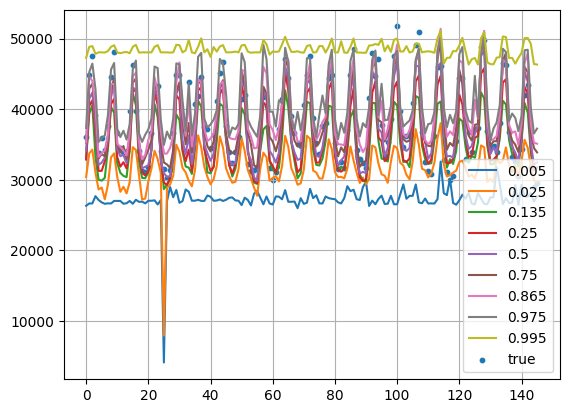

In [7]:
# kfold
prefixes = ['autoquantiles_']
features_train, features_validation, targets_train, targets_validation =\
    train_test_split(features, targets, train_size = .9, shuffle=False, random_state=42)
    # train_test_split(features[[c for c in features.columns if prefixes_in_column(c, prefixes)]], targets, train_size = .8, shuffle=False, random_state=42)


# undersample training features
# under_sample_pct = 
# features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size=under_sample_pct, shuffle=False, random_state=42)

params = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    # 'subsample': .9,
    # 'subsample_freq': 1,
    "num_leaves": 30,
    # "min_child_weight": .1,
    # "min_child_samples": 4,
    "hist_pool_size": 1000,
    'feature_fraction': 0.9, #.5
    # 'bagging_fraction': .8,
    "learning_rate": 0.005, #0.07,
    "n_estimators": 2000,#100
    "max_depth": 10,
    # 'reg_sqrt': True,
    # 'req_lambda': .00001,
    # 'reg_alpha': .00001,
    'alpha': .25,
    'verbose': 0
}

# # normalize
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# targets_train = scaler\
#     .fit_transform(targets_train.values.reshape(-1,1))\
#     .reshape(-1)
# targets_validation = scaler\
#     .transform(targets_validation.values.reshape(-1,1))\
#     .reshape(-1)

# train lgb model       
for q in [0.005, 0.025, 0.135, 0.25, 0.5, 0.75, 0.865, 0.975, 0.995]:
    params['alpha'] = q 
    temp_dict = {}
    mod: lgb.Booster = lgb.train(params, 
        train_set = lgb.Dataset(features_train, targets_train),
        valid_sets = lgb.Dataset(features_validation, targets_validation),
        evals_result = temp_dict,
        verbose_eval = False
    )
    plt.plot(mod.predict(features_validation), label = f'{q}')

# # plot prediction vs. true outcome (with quantile regression, this should correspond to confidence bounds)
# n = 100000000
# idx = targets_validation[:n].index
# plt.scatter(idx, mod.predict(features_validation)[:n], label = 'pred', s = 10)
# plt.scatter(idx, targets_validation[:n], label = 'true', s = 10)
# plt.legend()
# plt.grid()
# plt.show()
plt.scatter(range(len(targets_validation.index)), targets_validation, label = 'true', s = 10)
plt.legend()
plt.grid()
plt.show()

# # plot distribution of residuals, should have roughly q*n values on the left, and (1-q)*n values on the right
# plt.hist(mod.predict(features_validation) - targets_validation, bins=200)
# plt.show()

# # plot histogram of targets 
# plt.hist(targets)
# plt.grid()
# plt.show()

# # plot log(loss) of training iterations to get insights in convergence
# plt.plot(np.log(temp_dict["valid_0"]["quantile"]))
# plt.grid()
# plt.show()

# # plot feature importance
# lgb.plot_importance(mod)
# plt.show()

### Quick Run for Testing Cross Validation

In [8]:
# total ~280 seconds
lgb_quantile_params = {     # fairly well tuned, with high runtimes 
    'max_depth': [10, 20],
    'n_estimators': [ 150, 200, 200],  # 300, 350, 400, ],   
    'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    'min_child_samples': [ 2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 100, 100, 
                                        130, 170, 200, 300, 500, 700, 1000 ],
    'min_child_weight': [0, 0, 0, 0, 1e-4, 1e-3, 1e-3, 1e-3, 5e-3, 2e-2, 0.1 ],
    'num_leaves': [ 20, 30, 50, 50 ], # 50, 70, 90, ],
    'learning_rate': [  0.04, 0.05, 0.07, 0.07, 0.07, 0.1, 0.1, 0.1 ],   # 0.02, 0.03,        
    'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
    'reg_lambda': [0, 0, 0, 0, 1e-5, 1e-5, 1e-5, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100   ],
    'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-4, 1e-3, 3e-3, 1e-2, 0.1, 1, 1, 10, 10, 100, 1000,],
    'subsample': [  0.9, 1],
    'subsample_freq': [1],
    'cat_smooth': [0.1, 0.2, 0.5, 1, 2, 5, 7, 10],
}

params = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    # 'eval_at': 10,
    'hist_pool_size': 1000,
    # 'verbose_eval': 0
    # 'subsample': 0.5,
    # 'subsample_freq': 1,
    # 'feature_fraction': 0.5,
    # 'boost_from_average': False,
}

param_grid = {
    'max_depth': [10],
    'n_estimators': [50, 100, 200],
    # 'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    'min_child_samples': [4],
    'min_child_weight': [0.1 ],
    'num_leaves': [30], # 50, 70, 90, ],
    'learning_rate': [  0.04, 0.07, 0.1 ],   # 0.02, 0.03,        
    # 'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    # 'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
    # 'reg_lambda': [0, 1e-5, 1e-5, 1e-4, 1e-2, 1, 10, ],
    # 'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100, 1000,],
    'subsample': [  0.9, 1],
    'subsample_freq': [1],
}

In [ ]:

# ld = LoadData()
# features_train, targets_train = ld.prep_data('Level2', 1802)
for q in QUANTILES:
    params['alpha'] = q
    best_res, res = grid_search(params, param_grid, features_train, targets_train, 1)
    
    mod = lgb.train(best_res['params'],
        train_set = lgb.Dataset(features_train, targets_train)
    )
    predictions = mod.predict(features_validation)
    plt.plot(predictions, label = str(q))

plt.scatter(range(len(targets_validation)), targets_validation)
plt.legend()
plt.grid()
plt.show()

# Train + Predict submission

In [9]:
def train_level_all_quantiles(
    agg_level: str, 
    type_of: str, 
    sub_d_start: int, 
    exclude_columns: list = [], 
    test: bool = False, 
    do_grid_search: bool = False, 
    store_submissions_path: str = 'temp_submissions/', 
    sparse: bool = False,
    normalize: bool = False
    ):
    """ 
    Train, for a specific aggregation level, models for all quantiles.
    For aggregation levels 10, 11 and 12, undersampling is used to drastically reduce training time.
    """
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    if len(agg_columns) == 0:
        agg_str: str = 'Total_X'
    elif len(agg_columns) == 1:
        agg_str: str = f'{agg_columns[0]}_X'
    else:
        agg_str: str = '_'.join(agg_columns)

    # try:
    #     features = pd.DataFrame(features)
    # except Exception:
    # loading features
    logger.info('(re)loading features')
    features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
    features = _down_cast(features)
    features_gr = features.copy()

    group_columns = agg_columns
    res: list = []

    # select features
    if USE_ALL:
        pass
    elif SPARSE_FEATURES:
        columns = [c for c in features_gr if c in SPARSE_FEATURES] + ['sold', 'd'] + group_columns
        features_gr = features_gr[columns]
    elif sparse:
        pass
    else:
        # exclude features from exclusion prefix list
        exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal
        columns = [c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]
        features_gr = features_gr[columns]
    
    # preparations
    # sub_d_start = SUB_D_START_VAL if type_of == 'val' else SUB_D_START_EVAL
    train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1000)])
    pred_idx = features_gr['d'].isin([f'd_{sub_d_start + i}' for i in range(28)])
    df_train = features_gr[train_idx]
    df_pred = features_gr[pred_idx]
    features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
    targets_train: pd.Series = df_train['sold']
    features_predict: pd.DataFrame = df_pred.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
    targets_test: pd.Series = df_pred['sold']
    
    # undersample data
    if agg_level in undersampling_dict and HIGH_UNDERSAMPLING:
        undersampling_pct = undersampling_dict[agg_level]
        features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size = undersampling_pct, shuffle=True, random_state=43)

    # normalise targets
    if normalize:
        logger.info('scaling targets')
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        targets_train = scaler.fit_transform(targets_train.values.reshape(-1,1))
        
    # REMOVE THIS
    import matplotlib.pyplot as plt
    if PLOT_PREDICTIONS:
        fig, ax = plt.subplots(1,1, figsize = (10,5))
        aaa = [i for i in range(targets_test.shape[0])]
    # plt.scatter(aaa, targets_test, label = 'true')
    # REMOVE THIS
        
    # train model for all quantiles
    for quantile in QUANTILES:
        
        # perform grid search for best parameters
        if do_grid_search == True:
            # split data to training and testing
            # logger.info('divide for cross validation')
            # x_train, x_test, y_train, y_test = train_test_split(features_train, targets_train, train_size=.8, shuffle=False, random_state=42)
            # train_data = lgb.Dataset(x_train, y_train)
            # validation_data = lgb.Dataset(x_test, y_test)
            logger.info('perform gridsearch')
            params['alpha'] = quantile
            best_combination, results = grid_search(params, param_grid, features_train, targets_train, 1)
            # del train_data; del validation_data
            params_grid_train = best_combination["params"]
        else:
            params_grid_train = PARAM_GRID_TRAIN
            params_grid_train['alpha'] = quantile

        # train_best_model
        # logger.info(f'features: {str(features_train.columns)}')
        mod = lgb.train(params_grid_train,
            train_set = lgb.Dataset(features_train, targets_train)
        )
        predictions = mod.predict(features_predict)
        if normalize:
            predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,)
        
        # REMOVE THIS
        if PLOT_PREDICTIONS:
            ax.plot(aaa, predictions, label = f'{quantile}')
        # lgb.plot_importance(mod)
        # REMOVE THIS
        
        # store predictions
        df_p = pd.DataFrame(
            {
                'pred': predictions,
                'd': df_pred['d'],
            }
        )
        df_p['quantile'] = quantile
        df_p['Level'] = agg_level
        df_p['type_of'] = 'validation' if type_of == 'val' else 'evaluation'
        if len(agg_columns) == 0:
            df_p['agg_column1'] = 'Total'
            df_p['agg_column2'] = 'X'
        elif len(agg_columns) == 1:
            df_p['agg_column1'] = df_pred[agg_columns[0]].values
            df_p['agg_column2'] = 'X'
        else:
            df_p['agg_column1'] = df_pred[agg_columns[0]].values
            df_p['agg_column2'] = df_pred[agg_columns[1]].values
            
        df_p = df_p[['Level', 'agg_column1', 'agg_column2', 'd', 'quantile', 'pred', 'type_of']]
        
        res.append(_down_cast(df_p))
        
    # REMOVE THIS
    if PLOT_PREDICTIONS:
        ax.legend()
        plt.show()
    # REMOVE THIS
        
    # remove to reduce memory usage asap
    del features
        
    # storing predictions in specified file + folder
    df_sub_val = pd.concat(res)
    group_names = '_'.join(group_columns)
    if group_names == '':
        group_names = 'Total_X'
        
    if USE_ALL:
        df_sub_val.to_csv(f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_use_all.csv', index = False)
        logger.info('saved under: ' + f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_use_all.csv')
    elif SPARSE_FEATURES or sparse:
        df_sub_val.to_csv(f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_sparse.csv', index = False)
        logger.info('saved under: ' + f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_sparse.csv')
    else:    
        exclude_names = 'None' if len(exclude_prefix_list) == 0 else '_'.join(exclude_prefix_list)
        df_sub_val.to_csv(f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_{exclude_names}.csv', index = False)
        logger.info('saved under: ' + f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_{exclude_names}.csv')

2023-11-15 23:27:26 - __main__ - INFO - starting with agg_level: Level1
2023-11-15 23:27:26 - __main__ - INFO - (re)loading features


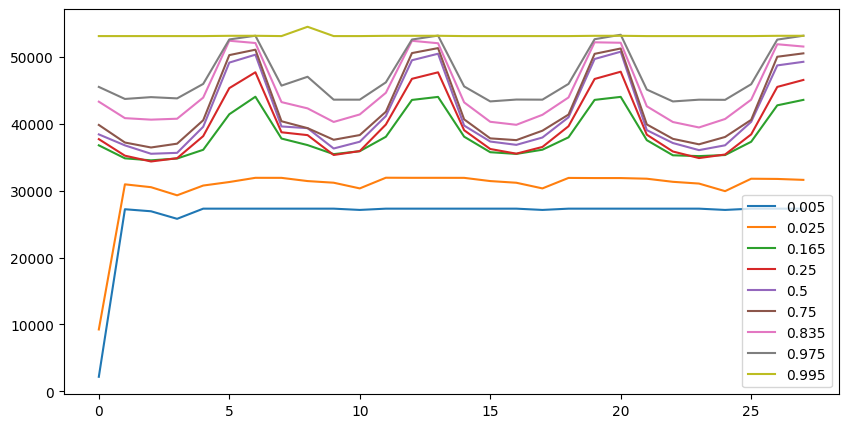

2023-11-15 23:27:51 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_Total_X_exclude_use_all.csv
2023-11-15 23:27:51 - __main__ - INFO - starting with agg_level: Level2
2023-11-15 23:27:51 - __main__ - INFO - (re)loading features


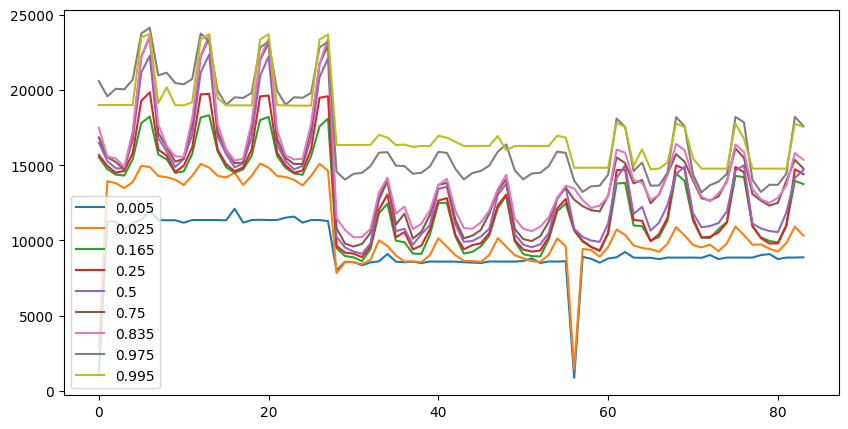

2023-11-15 23:28:42 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_exclude_use_all.csv
2023-11-15 23:28:42 - __main__ - INFO - starting with agg_level: Level3
2023-11-15 23:28:42 - __main__ - INFO - (re)loading features


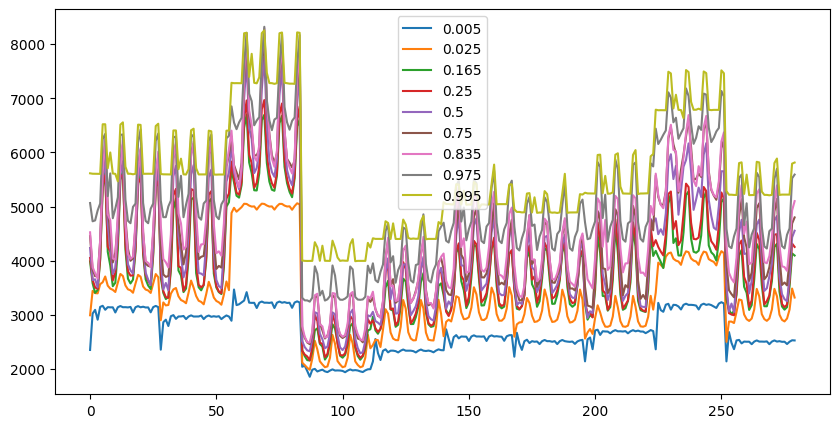

2023-11-15 23:29:42 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_exclude_use_all.csv
2023-11-15 23:29:42 - __main__ - INFO - starting with agg_level: Level4
2023-11-15 23:29:42 - __main__ - INFO - (re)loading features


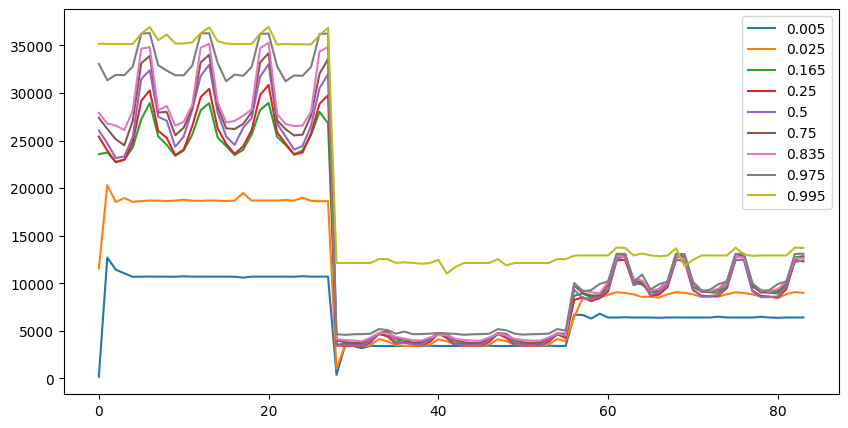

2023-11-15 23:30:26 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_cat_id_exclude_use_all.csv
2023-11-15 23:30:26 - __main__ - INFO - starting with agg_level: Level5
2023-11-15 23:30:26 - __main__ - INFO - (re)loading features


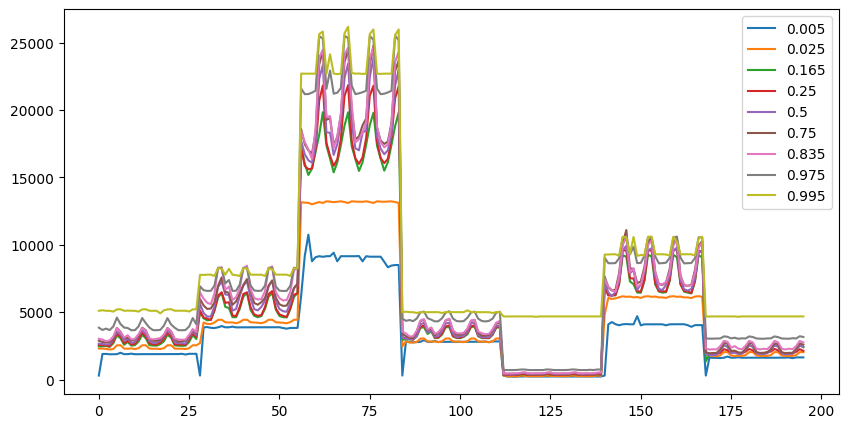

2023-11-15 23:31:19 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_dept_id_exclude_use_all.csv
2023-11-15 23:31:19 - __main__ - INFO - starting with agg_level: Level6
2023-11-15 23:31:19 - __main__ - INFO - (re)loading features


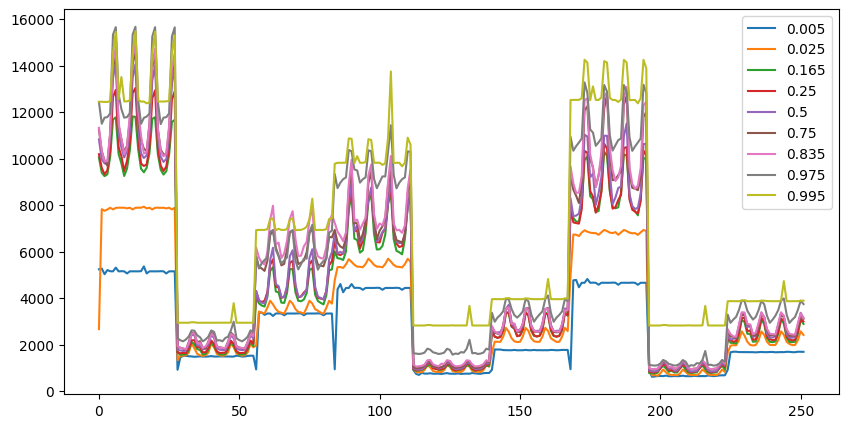

2023-11-15 23:32:22 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_use_all.csv
2023-11-15 23:32:22 - __main__ - INFO - starting with agg_level: Level7
2023-11-15 23:32:22 - __main__ - INFO - (re)loading features


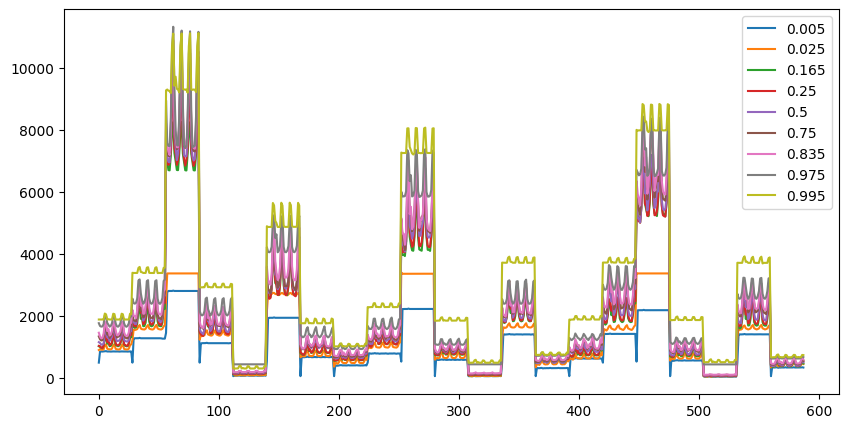

2023-11-15 23:33:36 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_use_all.csv
2023-11-15 23:33:36 - __main__ - INFO - starting with agg_level: Level8
2023-11-15 23:33:36 - __main__ - INFO - (re)loading features


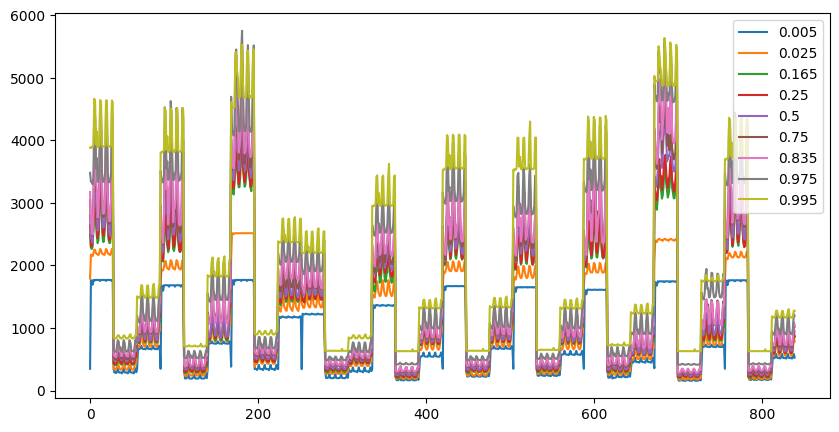

2023-11-15 23:35:01 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_use_all.csv
2023-11-15 23:35:01 - __main__ - INFO - starting with agg_level: Level9
2023-11-15 23:35:01 - __main__ - INFO - (re)loading features


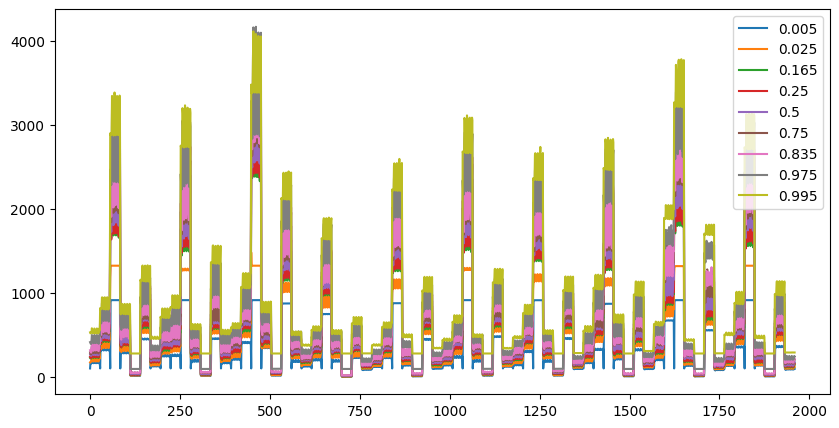

2023-11-15 23:36:47 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_use_all.csv


In [10]:
# all groups: seasonal, auto, autoquantiles, momentum
EXCLUDE_COLUMNS_LIST = (
    # [],
    # ['seasonal'],
    # ['momentum'],
    # ['autoquantiles'],
    # ['auto'],
    ['seasonal', 'auto', 'momentum'],
    # ['auto', 'momentum']
)

SPARSE_FEATURES = [
    'seasonal_Monday', 'seasonal_Tuesday', 'seasonal_Wednesday', 'seasonal_Thursday', 'seasonal_Friday', 'seasonal_Saturday', 'seasonal_Sunday',
    'autoquantiles_sold_ma_28_0.5', 'days_fwd', 'auto_sold_ma_28', 'auto_sold_ma_168', 'autoquantiles_sold_ma_168_0.165','autoquantiles_sold_ma_168_0.835',
]
SPARSE_FEATURES += [f'seasonal_month{i}' for i in range(1,32)]
SPARSE_FEATURES += [f'seasonal_{i}' for i in range(1,13)]
# SPARSE_FEATURES += [f'state_{i}' for i in ['CA', 'TX', 'WI']]

USE_ALL = True
PLOT_PREDICTIONS=True
# SPARSE_FEATURES = None

# sparse_features = ['dayofweek', 'dayofmonth', 
#                      'qs_30d_ewm', 'qs_100d_ewm',
#                     'qs_median_28d', 'qs_mean_28d',# 'qs_stdev_28d',
#                     'state_id',
#                #     'store_id',
#                    'qs_qtile90_28d',
#                     'pct_nonzero_days_28d',
#                     'days_fwd'
#                     ]

undersampling_dict = {
    # 'Level1': 0.5,
    # 'Level2': 0.2,
    # 'Level3': 0.2,
    # 'Level4': .3,
    # 'Level5': .15,
    # 'Level6': .15,
    # 'Level7': .15,
    # 'Level8': .15,
    # 'Level9': .1,
    'Level10': .001,
    'Level11': .0001,
    'Level12': .00001
}

HIGH_UNDERSAMPLING = True
TEST_NUMBER = 9
TEST_NUMB = 0
PARAM_GRID_TRAIN = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    # 'subsample': .9,
    # 'subsample_freq': 1,
    "num_leaves": 30,
    # "min_child_weight": .1,
    # "min_child_samples": 4,
    "hist_pool_size": 1000,
    
    # 'feature_fraction': 0.9, #.5
    # 'bagging_fraction': .8,
    
    "learning_rate": 0.005, # .07
    "n_estimators": 2000,#100
    "max_depth": 10,
    # 'reg_sqrt': True,
    # 'req_lambda': .00001,
    # 'reg_alpha': .00001,
}

params = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -100,
    'n_jobs': 4,
    # 'eval_at': 10,
    'hist_pool_size': 1000,
    'verbose_eval': -100,
    # 'boost_from_average': False,
}

param_grid = {
    'max_depth': [10, 20],
    'n_estimators': [50, 100, 200],
    # 'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    'min_child_samples': [4],
    'min_child_weight': [0,0.1],
    'num_leaves': [20, 30], # 50, 70, 90, ],
    'learning_rate': [0.04, 0.07, 0.1],   # 0.02, 0.03,        
    # 'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    # 'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
    # 'reg_lambda': [0, 1e-5, 1e-5, 1e-4, 1e-2, 1, 10, ],
    # 'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100, 1000,],
    'subsample': [ 0.9, 1 ],
    'subsample_freq': [1],
}

for exclude_columns in EXCLUDE_COLUMNS_LIST: # for each specified feature combination
    # for sub_d_start in D_CROSS_VAL_START_LIST: # for each fold
    for sub_d_start in D_CROSS_VAL_START_LIST[-1:]:#[:1 if TEST_NUMBER>0 else 100]:
        for agg_level in list(AGG_LEVEL_COLUMNS.keys())[TEST_NUMB:TEST_NUMBER]: # for each aggregation level
            logger.info(f'starting with agg_level: {agg_level}')
            train_level_all_quantiles(
                agg_level,
                sub_d_start=sub_d_start,
                type_of='val', 
                exclude_columns=exclude_columns,
                do_grid_search=False,
                store_submissions_path='temp_submissions_research/',
                sparse = False,
            )

### Load val + eval prediction files and merge to one submission file

In [11]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
#     i = str(1802)
#     dfs.append(
#         f'../data/uncertainty/fold_{i}/temp_submissions/' + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_val = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_validation = df_sub_val.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_validation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [12]:
def read_concat_predictions(fold_name: int, exclude_columns: list = [], load_submissions_path: str = 'temp_submissions/'):
    """ 
    For specified fold, read the predictions for all aggregation levels and stack them together in one dataframe.
    """
    # D_CV_START_LIST
    # if fold_name not in D_CV_START_LIST:
        # raise ValueError('fold_name must be a value in D_CV_START_LIST')
        
    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/' + load_submissions_path)

    dfs: list = []
    for level in list(AGG_LEVEL_COLUMNS.keys())[TEST_NUMB:TEST_NUMBER]:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'

        dfs.append(
            f'../data/uncertainty/fold_{fold_name}/' + load_submissions_path + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
        )
    return ensemble_submissions_uncertainty(dfs)

In [13]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
        
#     dfs.append(
#         PREDICTION_BASE_PATH + f'lgb_multivariate_eval_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_eval = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_evaluation = df_sub_eval.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_evaluation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [14]:
# # sub_evaluation = pd.read_csv('../submissions/submission_baseline_evaluation.csv').drop(['Unnamed: 0'], axis=1)
# pd.concat([sub_validation, sub_evaluation]).to_csv(SUBMISSION_BASE_PATH + f'submission_lgb_ensemble{exclude_columns}.csv', index=False)
# del sub_validation; del sub_evaluation

### For Validation Prediction, we can compute WRMSSE locally

In [15]:
# these variables are used later on
FORCE_RELOAD = False
try:
    # simple code to check if variable exists
    d_int + 1
    if FORCE_RELOAD:
        raise Exception()
except:
    # if not, load again
    # takes about 2-3 minutes to reload and parse
    d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
    d_int = pd.read_parquet('../data/uncertainty/cv_template/temp_d_int.parquet')['d_int']
    # d_int = d['d'].str.split('_').apply(lambda x: int(x[1]))
    # d_int.to_frame('d_int').to_parquet('../data/uncertainty/cv_template/temp_d_int.parquet', index = False)

In [16]:
def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    df_sub['id_merge'] = df_sub['id'].str.split('.')\
        .apply(lambda x: x[0])
    df_sub['quantile'] = df_sub['id'].str.split('.')\
        .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))

    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='left',
        on=['id_merge', 'd']
    )
    # del df; del df_sub_val
    p['id_merge'] = p['id_merge'].astype(str)

    for c in ['sold', 'revenue']:
        p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]

    return WSPL(p, [f'd_{i}' for i in range(D_CV_START, D_CV_START + 500)])

In [17]:

EXCLUDE_COLUMNS_LIST = (
    [],
    ['seasonal'],
    ['auto'],
    ['autoquantiles'],
    ['momentum'],
)

EXCLUDE_COLUMNS_LIST = (
    # ['seasonal'],
    # ['momentum'],
    # ['autoquantiles'],
    ['seasonal', 'auto', 'momentum'],
    ['auto', 'momentum'],
)

EXCLUDE_COLUMNS_LIST = (
    # ['sparse'],
    ['use_all'],
)

for EXCLUDE_COLUMNS in EXCLUDE_COLUMNS_LIST:
    logger.info('--------------- ' + str(EXCLUDE_COLUMNS) + ' ---------------')
    res = []
    for D_CV_START in D_CROSS_VAL_START_LIST[-1:]:#[:1 if TEST_NUMBER>0 else 10]:
        mean_wspl = perform_cv(_down_cast(d)[d_int < (D_CV_START + DAYS)], read_concat_predictions(D_CV_START, EXCLUDE_COLUMNS, 'temp_submissions_research/'))
        res.append(mean_wspl)
        logger.info(str(D_CV_START) + ' - wspl: ' + str(mean_wspl))

    logger.info(str(D_CV_START) + ' - mean wspl: ' + str(np.mean(res)) + ' +/- ' + str(np.std(res)))
    logger.info(str(D_CV_START) + ' - raw results: ' + str(res))

2023-11-15 23:36:57 - __main__ - INFO - --------------- ['use_all'] ---------------
2023-11-15 23:37:10 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1914/temp_submissions_research/
2023-11-15 23:37:35 - utils.metrics - INFO - reading weights file
2023-11-15 23:37:35 - utils.metrics - INFO - sorting df on d ...
2023-11-15 23:38:07 - utils.metrics - INFO - entering loop ...
2023-11-15 23:38:14 - utils.metrics - INFO - Level1 - 0.20310555353289247
2023-11-15 23:38:15 - utils.metrics - ERROR - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2023-11-15 23:38:21 - utils.metrics - ERROR - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2023-11-15 23:38:41 - utils.metrics - ERROR - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2023-11-15 23:38:42 - utils.metrics - INFO - Level2 - 0.1971042905921619
2023-11-15 23:38:42 - utils.metrics - INFO - Level3 - 0.17634085558247026
2023-11-15 23

### Code Beneath can be used to create submission template
The submission template can be used to quickly insert your predictions.
It also contains all other (historical) sales to be able to compute the WRMSSE

In [4]:
sales_validation = pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION)
sales_evaluation = pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION)
calendar = pd.read_csv(DATA_BASE_PATH + CALENDAR)
sell_prices = pd.read_csv(DATA_BASE_PATH + SELL_PRICES)

df_val, submission_idx_val = data_preprocessing(sales_validation, calendar, sell_prices)
del sales_validation
df_eval, submission_idx_eval = data_preprocessing(sales_evaluation, calendar, sell_prices)
del sales_evaluation

df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]# & (df_val["sold"].notna())]
del df_val
df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]# & (df_eval["sold"].notna())]
del df_eval

In [7]:
dfs = []
df_eval_after_release['revenue'] = df_eval_after_release['sold'] * df_eval_after_release['sell_price']
for level in list(AGG_LEVEL_COLUMNS.keys()):
    c = AGG_LEVEL_COLUMNS[level]
    logger.info(level)
    agg_dict = {
        'sold': 'sum',
        'revenue': 'sum'
    }
    d1 = df_eval_after_release.groupby(c + ['d']).agg(agg_dict).reset_index(drop=False)
    d = pd.DataFrame({
        'd': d1['d'],
        'sold': d1['sold'],
        'revenue': d1['revenue']
    })
    if len(c) == 0:
        d['agg_column1'] = 'Total'
        d['agg_column2'] = 'X'
    elif len(c) == 1:
        d['agg_column1'] = d1[c[0]]
        d['agg_column2'] = 'X'
    else:
        d['agg_column1'] = d1[c[0]]
        d['agg_column2'] = d1[c[1]]
    d['id_merge'] = d['agg_column1'] + '_' + d['agg_column2']
    d['Level'] = level
    dfs.append(d[['Level', 'agg_column1', 'agg_column2', 'd', 'sold', 'revenue', 'id_merge']])
d = pd.concat(dfs)
d.head(50)
d.to_parquet('temp.parquet', index=False)

2023-08-17 17:27:39 - __main__ - INFO - Level1
2023-08-17 17:27:40 - __main__ - INFO - Level2
2023-08-17 17:27:44 - __main__ - INFO - Level3
2023-08-17 17:27:48 - __main__ - INFO - Level4
2023-08-17 17:27:51 - __main__ - INFO - Level5
2023-08-17 17:27:55 - __main__ - INFO - Level6
2023-08-17 17:28:00 - __main__ - INFO - Level7
2023-08-17 17:28:05 - __main__ - INFO - Level8
2023-08-17 17:28:10 - __main__ - INFO - Level9
2023-08-17 17:28:15 - __main__ - INFO - Level10
2023-08-17 17:28:21 - __main__ - INFO - Level11
2023-08-17 17:28:33 - __main__ - INFO - Level12


,Level,agg_column1,agg_column2,d,sold,revenue,id_merge
0,Level1,Total,X,d_10,24858.0,63029.78,Total_X
1,Level1,Total,X,d_100,23653.0,65665.71,Total_X
2,Level1,Total,X,d_1000,29241.0,82351.45,Total_X
3,Level1,Total,X,d_1001,33804.0,93975.55,Total_X
4,Level1,Total,X,d_1002,42447.0,118961.96,Total_X
5,Level1,Total,X,d_1003,40647.0,116052.48,Total_X
6,Level1,Total,X,d_1004,32039.0,89314.17,Total_X
7,Level1,Total,X,d_1005,29501.0,81688.96,Total_X
8,Level1,Total,X,d_1006,31117.0,85754.15,Total_X
9,Level1,Total,X,d_1007,27018.0,74244.86,Total_X


In [ ]:
# file = open('test.txt')
# file.close